<a href="https://colab.research.google.com/github/erica-mccormick/tutorials/blob/main/Introduction_to_GEE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Introduction to Google Earth Engine**

Erica McCormick | 09/15/2021

#**Part 1**: Getting set up with GEE and Drive

*   Prior to using GEE for the first time, you must register [here](https://earthengine.google.com/new_signup/)
*   If you intend to use Python from the terminal or Jupyter Notebooks, I suggest setting up a conda environment for GEE using [this](https://developers.google.com/earth-engine/guides/python_install-conda#install_api) tutorial. After that, you will not have to authenticate GEE at the start of each session unless you use GoogleColab.

In [ ]:
import ee
ee.Authenticate()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=m-l9CEVENHllTxcb72Xi_j_nBDUDeiyi_2eOojrqiS4&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWjQUyZOtjlrUmdluaAe5ceoaAXxR24UhcOBQoDg_ZY7pKzxAOho43M

Successfully saved authorization token.


In [ ]:
ee.Initialize()

Connect your GoogleDrive. Once you've done this, you can import and export files directly to your drive. This is the only way to export results from GEE if you are using GoogleColab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**Part 2**: GEE basic terminology

##Python API
*   We are using the GEE Python API. You can also interact with GEE in the Javascript based [CodeEditor](https://code.earthengine.google.com/).
*   The Python API is not as well documented as Javascript, so be prepared to do some digging when you run into questions.
*   All of your assets and exports from GEE in Python will be visible in the CodeEditor dashboard.
*   I **highly** recommend using [this website](https://developers.google.com/earth-engine/apidocs) to check the documentation on any functions you use (on the left, click the dropdown arrow for "Client Libraries" and do a ctrl-f to search for the function). GEE can be very counterintuitive and oftentimes picks bad default settings that you want to know about.


##Raster Terminology
*   **Asset**: what you call GEE data
*   **Image**: single raster, may have multiple bands
*   **ImageCollection**: stack of rasters, usually representing a timeseries
*   **Reducer**: function to go from a collection --> image or from an image --> single value.  More on this later!





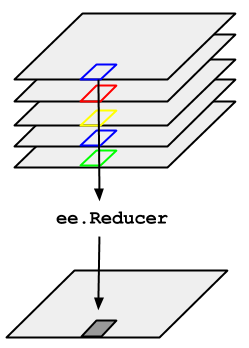

##Vector Terminology
*   **Geometry**: a special feature or a property of a feature that is just a cohesive geometry. You can create these out of a single lat/long, for example, or call this property if it exists with a feature (for example a shapefile of a state).
*   **Feature**: a single vector, point, etc.
*   **FeatureCollection**: a group of vector data which each retain their own geometry and property details

Both images and features have **properties** as well as an ID, if they are in a collection. One way to explore the structure of these properties for a given asset is to open an object in the [CodeEditor](https://code.earthengine.google.com/), click on the "Inspector" on the right, and browse the dropdown information for a random pixel.

##Server vs Client

###Read more about this [here](https://developers.google.com/earth-engine/guides/client_server)



*   You are on the "client" side.
*   All of the objects (everything that starts ee.XXX) that we interact with are just "proxies" for real objects with real data that exist on the "server" side.
*   Things you do to objects only "happen" when they are pushed out to the server.
*   This means that your code may seem to run very quickly... *until* you try to actually view a result.

### Some notes on how this server/client setup may affect you:
*   In order to make calculations happen and see the result, you will either need to fully export the result (like a raster after you've done calculations with it), or you will need to run ".getInfo" (for example to see a value you have computed). Keep in mind that these tasks can take a LOT longer than you were expecting (especially the first time you run them). Avoid using .getInfo unless you absolutely need to use it. (See the link for more info).
*   There are some operations, like loops, which you should avoid at all costs in GEE. Instead, use functions like ".map". We can go over this more.
*   GEE stays computionally feasible in part because it does weird complicated stuff with parallel computing in the cloud (or something). You may have the option with some functions to set extra parameters to make your code run faster, such as "tileScale" when using reducers.



In [ ]:
def do_my_calc(image):
  result = image.divide(2)
  return image

my_result = image_collection.map(do_my_calc)

#**Part 3**: Finding, importing, uploading, and exporting datasets

You can upload your own assets in the CodeEditor, and even format them with metadata for sharing! [(Here's an example)](
https://code.earthengine.google.com/?asset=users/ericamccormick/Dbedrock
)

You can search for datasets already in GEE [here](https://developers.google.com/earth-engine/datasets/catalog). Once you find the page, such as this one for [ET](https://developers.google.com/earth-engine/datasets/catalog/CAS_IGSNRR_PML_V2), all you need is the "snippet," in this case: CAS/IGSNRR/PML/V2. This page also has a lot of important information.

In [ ]:
ET = ee.ImageCollection('CAS/IGSNRR/PML/V2')

You can also export your results as assets so they will show up in your CodeEditor. Note that while you can share the link and the "snippet" for these assets, it is not possible for other people to search for them or for others to see them in their own asset folder. You will also have to click on each asset and set the sharing settings in order for the snippet to work for other people. Another note: GEE asset folders are horrible to manipulate, so set up your folder structure as soon as possible and stick with it. I'll share the code for exporting as assets in the example.

#**Part 4**: Demonstration! Let's calculate mean annual precipitation for Texas...

### Getting our data ready to go

First lets get our precipitation dataset from GEE. We'll use the [PRISM dataset](https://developers.google.com/earth-engine/datasets/catalog/OREGONSTATE_PRISM_AN81d). Let's also import a geometry of California that I uploaded as an asset and made public.

In [ ]:
prism = ee.ImageCollection("OREGONSTATE/PRISM/AN81d")

# Because the original shapefile had a few parts to it - islands and such - here I select only the first item in the collection
tx = ee.Feature(ee.FeatureCollection("users/ericaelmstead/20_RockMoisture/Regions/tx").first())


PRISM includes temperature and precipitation, so let's take a look at all the bands and then select just the one we want.

NameError: ignored

In [ ]:
prism.first().bandNames().getInfo()

['ppt', 'tmean', 'tmin', 'tmax', 'tdmean', 'vpdmin', 'vpdmax']

In [ ]:
precip = prism.select('ppt')

In [ ]:
precip

Let's select a date range that we are interested in calculating the average precipitation for.

In [ ]:
start = "2010-10-01"
end = "2015-09-31"

precip_10_15 = precip.filterDate(start, end)

### Calculating MAP

There's also a faster way to get the mean of the years using the function  [ee.Filter.calendarRange()](https://developers.google.com/earth-engine/apidocs/ee-filter-calendarrange)... but I'll leave that one up to y'all!

In [ ]:
# First lets sum up every single day using an ImageCollection reducer:
sum_p = precip_10_15.reduce(**{
    'reducer': ee.Reducer.sum(),
  })

# Now we have an image, which you can check by just typing the name of the object. (Don't use "print" because it gets weird.)
sum_p

In [ ]:
# Now we can divide by the number of years. You can do .add(), .subtract(), .multiply(), and .divide() with numbers and with other rasters.
MAP = sum_p.divide(5)

Before we go any further, lets **.clip()** our images (currently CONUS) down to the shape of Texas. 

GEE uses pyramiding, so it is possible for assets to shapeshift their scale depending on what functions you use, and what (if any) parameters you set. If you want to force an image to be at a certain scale or projection (highly recommended), you lets add the **.reproject()** to this step as well.

Note: You can always string things together (including reducers and functions like .mean(), .stdev(), etc. Check out that link above for all of the functions. There are some pretty cool ones that do advanced GIS stuff! 

In [ ]:
MAP = MAP.clip(tx.geometry()).reproject(crs='EPSG:4326', scale=500)

### Masking to forested area

What if we only wanted to calculate MAP where there is forested or shrubby area in Texas?

In [ ]:
# Import our USGS National Land Cover Database asset
usgs_nlcd = ee.ImageCollection("USGS/NLCD_RELEASES/2016_REL")

In [ ]:
landsort = usgs_nlcd.sort('system:time_start', False) #sort backcwards to get most recent image
landsort = ee.Image(landsort.first()) # make sure to get just first image (ie the most recent)
img1 = landsort.select('landcover').reproject(crs='EPSG:4326', scale=30) #enforce the native scale

# One way to isolate a value is .eq(). You can also use .lt() or .gt() for < and >. All pixels that are accepted take "1" and the rest "0".
shrub = img1.eq(52) #mask to get all values = 52

# Alternatively, use .remap() to get only the classes you want.
forested = img1.remap([41,42,43],[1,1,1],0) #image.remap([from],[to],defaultVal).

## add binary images together to return a mask with 1s and 0s:
woody_veg = ee.Image(0).add(forested).add(shrub).clip(tx.geometry()) #.gt(0) #final binary tiff where 1s are places with woody veg

If we want to quickly visualize our rasters without exporting them, we can display a thumbnail. Sometimes these take a while. The vis parameters on thumbnails (and GEE visualizations in general) sucks.

*Note: this process goes from client to server side, so it will show you if you have errors or your computations are too time consuming!*


These thumbnails work best for binary images, but sometimes they don't work at all...

In [ ]:
# We can now mask our MAP by woody vegetation.
MAP_woody = MAP.updateMask(woody_veg)

In [ ]:
from IPython.display import Image

Image(url = MAP.clip(tx.geometry()).getThumbUrl({'min': 0, 'max': 2000, 'dimensions': 512,
                'palette': ["cfdee7","92b4f4","5e7ce2","4472ca","0a369d"]}))

EEException: ignored

In [ ]:
Image(url = MAP_woody.clip(tx.geometry()).getThumbUrl({'min': 0, 'max': 2000, 'dimensions': 512,
                'palette': ["cfdee7","92b4f4","5e7ce2","4472ca","0a369d"]}))

If you want to *really* explore a map in Colab, you can use the package [geemap](https://github.com/giswqs/geemap), which does lots of very exciting things and leverages folium and ipyleaflet for amazing visualizations! This could be a topic for another skillshare...

###Export image to drive

In [ ]:
to_save = woody_veg.toDouble().clip(tx.geometry()) # I have found that this .toDouble() is very important when exporting to drive. DON'T include it for exporting to an asset though.
task_config = {
        'region': tx.geometry(),
        'fileFormat': 'GeoTIFF',
        'fileNamePrefix': 'woody_veg',
        'image': to_save,
        'description': 'woody_veg',
        'scale': 500,
        'maxPixels': 10000000000000
    }

task=ee.batch.Export.image.toDrive(**task_config)
task.start()

In [ ]:
to_save = MAP.toDouble().clip(tx.geometry()) # I have found that this .toDouble() is very important when exporting to drive. DON'T include it for exporting to an asset though.
task_config = {
        'region': tx.geometry(),
        'fileFormat': 'GeoTIFF',
        'fileNamePrefix': 'skillshare_MAP',
        'image': to_save,
        'description': 'skillshare_MAP',
        'scale': 500,
        'maxPixels': 10000000000000
    }

task=ee.batch.Export.image.toDrive(**task_config)
task.start()

###Export image to asset

In [ ]:
task_config = {
        'region': tx.geometry(),
        'image': MAP,
        'description': 'skillshare_MAP',
        'assetId' : 'users/ericaelmstead/skillshare_MAP',
        'scale': 500,
        'maxPixels': 10000000000000
    }

task=ee.batch.Export.image.toAsset(**task_config)
task.start()

#**Part 5**: Point-level GEE calculations

One way to get a value for an area, for example the mean precipitation over our study site, is to use an **ImageReducer**. We used an **ImageCollection Reducer** before when calculating MAP.

One of these reducers is the **reduceRegion** function, which works for features and feature collections, including points.

In [ ]:
CO_Bend_SP = ee.Geometry.Point([-98.495119, 31.055434])
point_MAP = MAP.reduceRegion(ee.Reducer.first(), CO_Bend_SP, 1000)


In [ ]:
point_MAP.getInfo()

In [ ]:
MAP.bandNames().getInfo()

['ppt_sum']

There are two other ways to extract timeseries of a point (or feature, feature collection, etc) from an image collection. The way our lab has been doing it requires a bit of work for each new collection you want to extract from, but there are also some easier ways that I am just getting the hang of!

Say we have some sites that we want precipitation timeseries of:

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
docID = '1VtyuCPu80X4ohARm1_w-ifNoORw6BEVwocx-yV223-A'
gID = '0'
df = pd.read_csv('https://docs.google.com/spreadsheets/d/' + docID + '/export?gid=' + gID + '&format=csv')
df.head()

,Sites,Name,ID,Latitude,Longitude
0,ACRR,"Rempe and Dietrich, 2018",10,39.729000,-123.644000
1,SRR,"Hahm et al, 2019",11,39.574518,-123.477000
2,RV,"Pedrazas, 2020",12,39.152361,-122.348690
3,Soaproot,"O'Geen et al., 2018",13,37.028281,-119.254844
4,San Joaquin,"O'Geen et al., 2018",14,37.099393,-119.740149


First, we'll convert this table of lat/longs to a feature collection:

In [ ]:
lons = np.array(df['Longitude'])
lats = np.array(df['Latitude'])
ids = np.array(df['ID'])
site_names = df['Sites']

In [ ]:
fts_list = []
for i in range(len(ids)):
  ft = ee.Feature(ee.Geometry.Point((lons[i],lats[i])))
  ft = ft.set({'Site':str(ids[i])})
  fts_list.append(ft)

fts = ee.FeatureCollection(fts_list)

Now we'll grab our precipitation asset again, set the start and end dates, and then run some extraction code..

In [ ]:
prism = ee.ImageCollection("OREGONSTATE/PRISM/AN81d")

minyear = 2010
maxyear = 2011
variable = 'ppt'

path = '/content/drive/MyDrive/'

# Reduce regions on our feature collection
def extract(image):
        val = image.reduceRegions(fts, ee.Reducer.mean(), tileScale = 16, crs='EPSG:4326',scale=500)
        return val

#### .map()
#imagecollection.map(name_of_function)
#ndvi = my_landsat.map(calculate_ndvi)

def get_prism(minyear, maxyear, variable):
    dfs = []
    for year in range(minyear, maxyear):
      print('Getting year %s'%str(year))
      for month in range(1,13):
        start = (
          pd.to_datetime(str(year) + '-' + str(month)) - pd.to_timedelta(1,unit='D')
        ).strftime('%Y-%m-%d')
        if month==12:
          stop = (
            pd.to_datetime(str(year+1) + '-' + str(1)) - pd.to_timedelta(1,unit='D')
          ).strftime('%Y-%m-%d')
        else:
          stop = (
            pd.to_datetime(str(year) + '-' + str(month+1)) - pd.to_timedelta(1,unit='D')
          ).strftime('%Y-%m-%d')

        prism = ee.ImageCollection('OREGONSTATE/PRISM/AN81d').select(variable).filterDate(start, stop)
        extracted = prism.map(extract).flatten().getInfo()
        sites = []
        vals = []
        dates = []
        for feat in extracted['features']:
            site = feat['properties']['Site']
            try:
                val = feat['properties']['mean']
            except:
                val = np.nan
            date = pd.to_datetime(feat['id'].split('_')[0])
            sites.append(site), vals.append(val), dates.append(date)     
        df = pd.DataFrame(vals, index=dates, columns=[variable])
        df['site'] = sites
        df = df.pivot(columns='site')
        dfs.append(df)
    prism = pd.concat(dfs)
    return prism[variable]


def make_dataframe(variable, product):
  column_names = []
  for i in site_names:
    name = i + '_' + str(variable)
    column_names.append(name)

  df = product.copy()
  df.columns = column_names
  df.index.names = ['Date']

  return df

ppt = get_prism(minyear, maxyear, variable)
ppt_named = make_dataframe(variable, ppt)

with open(path + variable + '.csv', 'w') as f:
  ppt_named.to_csv(f)

Getting year 2010


In [ ]:
ppt = pd.read_csv('/content/drive/MyDrive/ppt.csv')
ppt.head()

,Date,ACRR_ppt,SRR_ppt,RV_ppt,Soaproot_ppt,San Joaquin_ppt,Providence Creek_ppt,McDonald_ppt,Freeman_ppt,Rocksprings_ppt,White _ppt,Slate_ppt,Gordon_ppt
0,2010-01-01,32.799,20.271999,0.423,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.033
1,2010-01-02,46.931,19.281000,2.648,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.116,0.001
2,2010-01-03,0.403,0.141000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.454,0.304
3,2010-01-04,0.000,0.000000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.013
4,2010-01-05,0.000,0.000000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000


In [ ]:
# Let's get the cumulative water year precip for a better plot
temp = ppt.copy()
temp['Date'] = pd.to_datetime(temp['Date'])
temp = temp.set_index('Date')
temp['wateryear'] = np.where(~temp.index.month.isin([10,11,12]),temp.index.year,temp.index.year+1)

ppt_wtryr = temp.groupby(['wateryear']).cumsum()

ppt_wtryr.head()

,ACRR_ppt,SRR_ppt,RV_ppt,Soaproot_ppt,San Joaquin_ppt,Providence Creek_ppt,McDonald_ppt,Freeman_ppt,Rocksprings_ppt,White _ppt,Slate_ppt,Gordon_ppt
Date,,,,,,,,,,,,
2010-01-01,32.799,20.271999,0.423,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.033
2010-01-02,79.730,39.552999,3.071,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.116,0.034
2010-01-03,80.133,39.693999,3.071,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.570,0.338
2010-01-04,80.133,39.693999,3.071,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.570,0.351
2010-01-05,80.133,39.693999,3.071,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.570,0.351


Text(0.5, 1.0, 'ACRR')

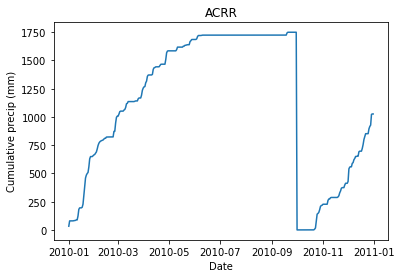

In [ ]:
plt.plot(ppt_wtryr.index, ppt_wtryr.ACRR_ppt)
plt.xlabel('Date')
plt.ylabel('Cumulative precip (mm)')
plt.title('ACRR')

Another way to accomplish a similiar task is to transform the image collection into a single image with many bands:

In [ ]:
start = "2010-01-01"
end = "2011-01-01"

precip_10_11 = precip.filterDate(start, end)

precip_10_11_image = precip_10_11.toBands()

In [ ]:
ACRR = ee.Geometry.Point([-123.644000, 39.729000])
ACRR_precip = precip_10_11_image.reduceRegion(ee.Reducer.first(), ACRR, 500)

ACRR_precip.getInfo()
